In [1]:
from pyspark import SparkConf, SparkContext
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import pandas as pd
import csv

In [2]:
def mapperE_dist(line):
    E_dist = 0
    for i in range(len(line[1][0])):
        E_dist += pow((float(line[1][0][i]) - float(line[1][1][i])), 2)
    E_dist = pow(E_dist, 0.5)
    return (tuple(line[1][0]), (tuple(line[1][1]), E_dist))

In [3]:
def mapperE_min(line):
    min_point = []
    min_dist = 1.7976931348623157e+308
    cnt = 0
    index = 0
    for i in range(10):
        if min_dist > line[1][2*i+1]:
            min_dist = line[1][2*i+1]
            min_point = line[1][2*i]
            index = i
    cnt = len(line[1]) / 20
    return ((index, tuple(min_point)), (cnt, (line[0], cnt*pow(min_dist, 2))))

In [4]:
def mapperNew_cen(line):
    new_cen = list(line[0][1])
    for i in range(len(line[0][1])):
        new_cen[i] = 0
    do = 0
    cnt = 0
    tmp_cnt = 0
    for l in line[1]:
        if do == 1:
            for i in range(len(line[0][1])):
                new_cen[i] += tmp_cnt*float(l[0][i])
            tmp_cnt = 0
        else:
            tmp_cnt = l
            cnt += tmp_cnt
        do = (do+1)%2
    for i in range(len(line[0][1])):
        new_cen[i] /= cnt
    return (line[0][0], (new_cen))

In [5]:
def mapperinit(line):
    return (0, line[1])

In [6]:
def mapperM_dist(line):
    M_dist = 0
    for i in range(len(line[1][0])):
        M_dist += abs(float(line[1][0][i]) - float(line[1][1][i]))
    return (tuple(line[1][0]), (tuple(line[1][1]), M_dist))

In [7]:
def mapperM_min(line):
    min_point = []
    min_dist = 1.7976931348623157e+308
    cnt = 0
    index = 0
    for i in range(10):
        if min_dist > line[1][2*i+1]:
            min_dist = line[1][2*i+1]
            min_point = line[1][2*i]
            index = i
    cnt = len(line[1]) / 20
    return ((index, tuple(min_point)), (cnt, (line[0], cnt*min_dist)))

In [8]:
COST = 0
data = sc.textFile("data.txt")
centroid1 = sc.textFile("c1.txt")
centroid2 = sc.textFile("c2.txt")
data = data.map(lambda line: (0, line.split(' ')))
centroid1 = centroid1.map(lambda line: (0, line.split(' ')))
centroid2 = centroid2.map(lambda line: (0, line.split(' ')))
centroid1_1 = centroid1
centroid2_1 = centroid2
E_cost_c1, E_cost_c2, M_cost_c1, M_cost_c2 = [], [], [], []
E_chage_c1, E_change_c2 = 0, 0
M_chage_c1, M_change_c2 = 0, 0


print("Euclidean distance with c1: ")
for i in range(20):
    newdata = data.join(centroid1_1)
    distance = newdata.map(mapperE_dist)
    distance = distance.reduceByKey(lambda a, b: a+b)
    mindistance = distance.map(mapperE_min)
    E_cost_c1.append(mindistance.values().values().values().sum())
    cal_new_cen = mindistance.reduceByKey(lambda a, b: a+b)
    cal_new_cen = cal_new_cen.map(mapperNew_cen)
    cal_new_cen = cal_new_cen.sortByKey()
    cal_new_cen = cal_new_cen.map(mapperinit)
    centroid1_1 = cal_new_cen

print("Euclidean distance with c2: ") 

for i in range(20):
    newdata = data.join(centroid2_1)
    distance = newdata.map(mapperE_dist)
    distance = distance.reduceByKey(lambda a, b: a+b)
    mindistance = distance.map(mapperE_min)
    E_cost_c2.append(mindistance.values().values().values().sum())
    cal_new_cen = mindistance.reduceByKey(lambda a, b: a+b)
    cal_new_cen = cal_new_cen.map(mapperNew_cen)
    cal_new_cen = cal_new_cen.sortByKey()
    cal_new_cen = cal_new_cen.map(mapperinit)
    centroid2_1 = cal_new_cen

Euclidean distance with c1: 
Euclidean distance with c2: 


C1            C2
0   6.236603e+08  4.387478e+08
1   5.098629e+08  2.498039e+08
2   4.854807e+08  1.944948e+08
3   4.639970e+08  1.698048e+08
4   4.609693e+08  1.562957e+08
5   4.605378e+08  1.490942e+08
6   4.603131e+08  1.425085e+08
7   4.600035e+08  1.323039e+08
8   4.595705e+08  1.171710e+08
9   4.590211e+08  1.085474e+08
10  4.584907e+08  1.022372e+08
11  4.579442e+08  9.827802e+07
12  4.575580e+08  9.563023e+07
13  4.572901e+08  9.379331e+07
14  4.570506e+08  9.237713e+07
15  4.568922e+08  9.154161e+07
16  4.567036e+08  9.104557e+07
17  4.564042e+08  9.075224e+07
18  4.561778e+08  9.047017e+07
19  4.559869e+08  9.021642e+07

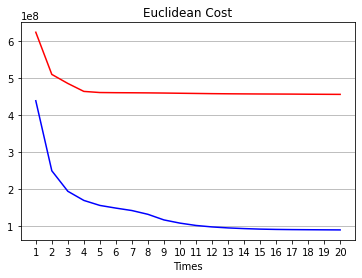

Change with c1 26.885383292517258
Change with c2 79.437750291599


In [9]:
E_cost_dict = {}
E_cost_dict["C1"] = E_cost_c1
E_cost_dict["C2"] = E_cost_c2
df = pd.DataFrame(E_cost_dict)
display(df)

iteration = range(1, 21)
plt.plot(iteration, E_cost_c1, "red")
plt.plot(iteration, E_cost_c2, "blue")
plt.title('Euclidean Cost')
plt.xlabel('Times')  
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.grid(axis='y')
plt.show()

E_change_c1 = (abs(E_cost_c1[19]-E_cost_c1[0]))/E_cost_c1[0]*100
E_change_c2 = (abs(E_cost_c2[19]-E_cost_c2[0]))/E_cost_c2[0]*100
print("Change with c1", E_change_c1)
print("Change with c2", E_change_c2)

In [10]:
print("------------------------------")
print("Manhattan distance with c1: ")

centroid1_2 = centroid1
centroid2_2 = centroid2
M_cost_c1 = []
M_cost_c2 = []

for i in range(20):
    newdata = data.join(centroid1_2)
    distance = newdata.map(mapperM_dist)
    distance = distance.reduceByKey(lambda a, b: a+b)
    mindistance = distance.map(mapperM_min)
    M_cost_c1.append(mindistance.values().values().values().sum())
    cal_new_cen = mindistance.reduceByKey(lambda a, b: a+b)
    cal_new_cen = cal_new_cen.map(mapperNew_cen)
    cal_new_cen = cal_new_cen.sortByKey()
    cal_new_cen = cal_new_cen.map(mapperinit)
    centroid1_2 = cal_new_cen
    
print("Manhatten distance with c2: ") 

for i in range(20):
    newdata = data.join(centroid2_2)
    distance = newdata.map(mapperM_dist)
    distance = distance.reduceByKey(lambda a, b: a+b)
    mindistance = distance.map(mapperM_min)
    M_cost_c2.append(mindistance.values().values().values().sum())
    cal_new_cen = mindistance.reduceByKey(lambda a, b: a+b)
    cal_new_cen = cal_new_cen.map(mapperNew_cen)
    cal_new_cen = cal_new_cen.sortByKey()
    cal_new_cen = cal_new_cen.map(mapperinit)
    centroid2_2 = cal_new_cen

------------------------------
Manhattan distance with c1: 
550117.142
464869.27587929735
470897.3822772978
483914.4091733448
489216.071003429
487629.6685499798
483711.9232137456
475330.77349323133
474871.23884636106
457232.9201150776
447494.38619735045
450915.0125766772
451250.3670725654
451974.5955397494
451570.36406995665
452739.0113664559
453082.7302871836
450583.6708602985
450368.74931674165
449011.3637255191
Manhatten distance with c2: 
1433739.3099999996
1084488.7769648791
973431.7146620421
895934.5925630709
865128.3352940821
845846.6470313492
827219.5827561263
803590.3456011105
756039.5172761205
717332.9025432304
694587.9252526884
684444.5019967911
674574.7475478557
667409.4699160267
663556.6278215036
660162.7772287574
656041.3222947128
653036.7540731605
651112.4262522729
649689.0131843531


C1            C2
0   550117.142000  1.433739e+06
1   464869.275879  1.084489e+06
2   470897.382277  9.734317e+05
3   483914.409173  8.959346e+05
4   489216.071003  8.651283e+05
5   487629.668550  8.458466e+05
6   483711.923214  8.272196e+05
7   475330.773493  8.035903e+05
8   474871.238846  7.560395e+05
9   457232.920115  7.173329e+05
10  447494.386197  6.945879e+05
11  450915.012577  6.844445e+05
12  451250.367073  6.745747e+05
13  451974.595540  6.674095e+05
14  451570.364070  6.635566e+05
15  452739.011366  6.601628e+05
16  453082.730287  6.560413e+05
17  450583.670860  6.530368e+05
18  450368.749317  6.511124e+05
19  449011.363726  6.496890e+05

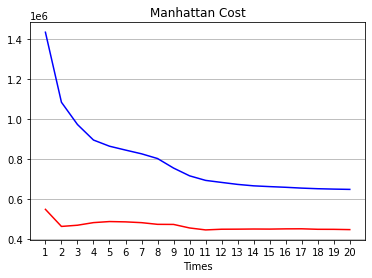

Change with c1:  18.378954327236887
Change with c2:  54.685694348134085


In [11]:
M_cost_dict = {}
M_cost_dict["C1"] = M_cost_c1
M_cost_dict["C2"] = M_cost_c2
df = pd.DataFrame(M_cost_dict)
display(df)

iteration = range(1, 21)
plt.plot(iteration, M_cost_c1, "red")
plt.plot(iteration, M_cost_c2, "blue")
plt.title('Manhattan Cost')
plt.xlabel('Times')  
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.grid(axis='y')
plt.show()

M_change_c1 = (abs(M_cost_c1[19]-M_cost_c1[0]))/M_cost_c1[0]*100
M_change_c2 = (abs(M_cost_c2[19]-M_cost_c2[0]))/M_cost_c2[0]*100
print("Change with c1: ", M_change_c1)
print("Change with c2: ", M_change_c2)

In [12]:
# Centroid c1 after calculate by Euclidean distance , now calculate its distance
cen = centroid1_1.collect()
cen_E_c1_E = []
cen_E_c1_M = []
# by Euclidean
with open('Euclidean_c1_EU.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        for j in range(10):
            tmp_dist = 0
            if j < i :
                cen_E_c1_E.append('')
            else:
                for k in range(58):
                    tmp_dist += pow((cen[i][1][k]-cen[j][1][k]), 2)
                tmp_dist = pow(tmp_dist, 0.5)
                cen_E_c1_E.append(tmp_dist)
        writer.writerow(cen_E_c1_E)
        cen_E_c1_E = []

# by Manhattan
with open('Euclidean_c1_Man.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        for j in range(10):
            tmp_dist = 0
            if j < i :
                cen_E_c1_M.append('')
            else:
                for k in range(58):
                    tmp_dist += abs((cen[i][1][k]-cen[j][1][k]))
                cen_E_c1_M.append(tmp_dist)
        writer.writerow(cen_E_c1_M)
        cen_E_c1_M = []

In [13]:
# Centroid c2 after calculate by Euclidean distance , now calculate its distance
cen = centroid2_1.collect()
cen_E_c2_E = []
cen_E_c2_M = []
# by Euclidean
with open('Euclidean_c2_EU.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        for j in range(10):
            tmp_dist = 0
            if j < i :
                cen_E_c2_E.append('')
            else:
                for k in range(58):
                    tmp_dist += pow((cen[i][1][k]-cen[j][1][k]), 2)
                tmp_dist = pow(tmp_dist, 0.5)
                cen_E_c2_E.append(tmp_dist)
        writer.writerow(cen_E_c2_E)
        cen_E_c2_E = []

# by Manhattan
with open('Euclidean_c2_Man.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        for j in range(10):
            tmp_dist = 0
            if j < i :
                cen_E_c2_M.append('')
            else:
                for k in range(58):
                    tmp_dist += abs((cen[i][1][k]-cen[j][1][k]))
                cen_E_c2_M.append(tmp_dist)
        writer.writerow(cen_E_c2_M)
        cen_E_c2_M = []

In [14]:
# Centroid c1 after calculate by Manhattan distance , now calculate its distance
cen = centroid1_2.collect()
cen_M_c1_E = []
cen_M_c1_M = []
# by Euclidien
with open('Manhattan_c1_EU.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        for j in range(10):
            tmp_dist = 0
            if j < i :
                cen_M_c1_E.append('')
            else:
                for k in range(58):
                    tmp_dist += pow((cen[i][1][k]-cen[j][1][k]), 2)
                tmp_dist = pow(tmp_dist, 0.5)
                cen_M_c1_E.append(tmp_dist)
        writer.writerow(cen_M_c1_E)
        cen_M_c1_E = []

# by Manhattan
with open('Manhattan_c1_Man.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        for j in range(10):
            tmp_dist = 0
            if j < i :
                cen_M_c1_M.append('')
            else:
                for k in range(58):
                    tmp_dist += abs((cen[i][1][k]-cen[j][1][k]))
                cen_M_c1_M.append(tmp_dist)
        writer.writerow(cen_M_c1_M)
        cen_M_c1_M = []

In [15]:
# Centroid c2 after calculate by Manhattan distance , now calculate its distance
cen = centroid2_2.collect()
cen_M_c2_E = []
cen_M_c2_M = []
# by Euclidien
with open('Manhattan_c2_EU.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        for j in range(10):
            tmp_dist = 0
            if j < i :
                cen_M_c2_E.append('')
            else:
                for k in range(58):
                    tmp_dist += pow((cen[i][1][k]-cen[j][1][k]), 2)
                tmp_dist = pow(tmp_dist, 0.5)
                cen_M_c2_E.append(tmp_dist)
        writer.writerow(cen_M_c2_E)
        cen_M_c2_E = []

# by Manhattan
with open('Manhattan_c2_Man.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        for j in range(10):
            tmp_dist = 0
            if j < i :
                cen_M_c2_M.append('')
            else:
                for k in range(58):
                    tmp_dist += abs((cen[i][1][k]-cen[j][1][k]))
                cen_M_c2_M.append(tmp_dist)
        writer.writerow(cen_M_c2_M)
        cen_M_c2_M = []

In [16]:
sc.stop()